# Анализ бизнес метрик

#### Введение:
Мы занимаемся маркетинговой аналитикой развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.  

Нам предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

Загрузм данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.
Изучим данные и выполним предобработку.

In [1]:
# загрузка библиотек

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Откроем файлы, отобразим их и посмотрим общую информацию о них. Посмотрим количество пропусков и дубликатов.

In [2]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
purchases = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
marketing = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')
display(purchases.head())
marketing.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [3]:
visits.info()
print()
purchases.info()
print()
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column 

In [4]:
# смотрим количество пропусков
display(visits.isna().sum())
display(purchases.isna().sum())
marketing.isna().sum()

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

User Id     0
Event Dt    0
Revenue     0
dtype: int64

dt         0
Channel    0
costs      0
dtype: int64

In [5]:
# смотрим количество дубликатов
display(visits.duplicated().sum())
display(purchases.duplicated().sum())
marketing.duplicated().sum()

0

0

0

Видим что пропусков и дубликатов в файлах нет. Приведём названия полей к "змеиному" регистру. В столбцах, где хранится дата изменим тип данных на datetime.

In [6]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
purchases.columns = ['user_id', 'event_dt', 'revenue']
marketing.columns = ['dt', 'channel', 'costs']

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])
marketing['dt'] = pd.to_datetime(marketing['dt']).dt.date

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функции для вычисления значений метрик:

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Функции для построения графиков:

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулием выводы.

#### Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [16]:
profiles = get_profiles(visits, purchases, marketing)
display(profiles.head())

max_date = profiles['first_ts'].max().date()
min_date = profiles['first_ts'].min().date()
print(f'Максимальная дата: {max_date}')
print(f'Минимальня дата: {min_date}')

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769

Максимальная дата: 2019-10-27
Минимальня дата: 2019-05-01


#### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

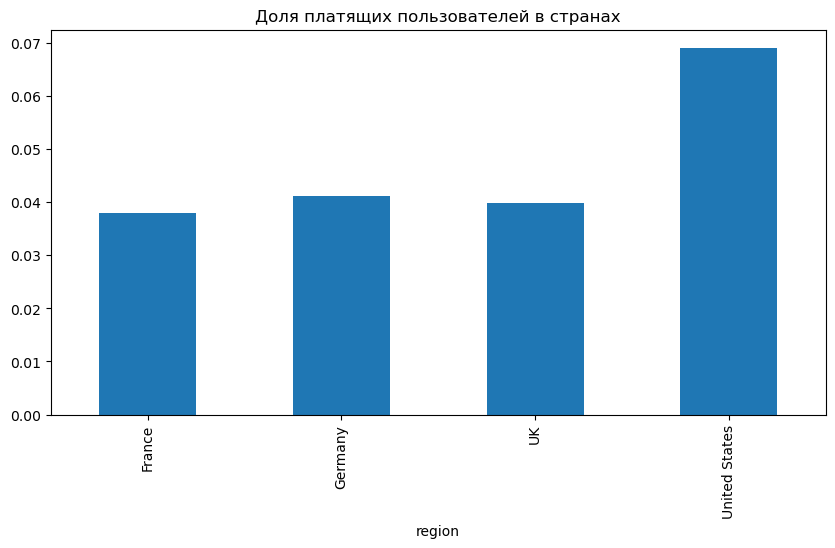

In [17]:
profiles.groupby('region')['payer'].mean().plot(kind='bar', figsize=(10,5));
plt.title('Доля платящих пользователей в странах')
plt.show()

In [18]:
countries = profiles.pivot_table(index='region', aggfunc={'user_id':'count', 'payer':'mean'})
#countries['payer'] = countries['payer'] * countries['user_id'] / countries['user_id'].sum()
countries.sort_values(by='payer', ascending=False)

payer  user_id
region                          
United States  0.069019   100002
Germany        0.041119    14981
UK             0.039829    17575
France         0.037994    17450

В Соединённых Штатах больше всего пользователей, и платящих пользователей в штатах так же больше всего.

#### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [19]:
devices = profiles.pivot_table(index='device', aggfunc={'user_id':'count', 'payer':'mean'})
#devices['payer'] = devices['payer'] * devices['user_id'] / devices['user_id'].sum() * 100
devices.sort_values(by='payer', ascending=False)

payer  user_id
device                    
Mac      0.063644    30042
iPhone   0.062079    54479
Android  0.058518    35032
PC       0.050468    30455

Больше всего приложением пользуются с iPhone. Доля платящий самая большая на Mac.

#### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [20]:
channels = profiles.pivot_table(index='channel', aggfunc={'user_id':'count', 'payer':'mean'})
#channels['payer'] = channels['payer'] * channels['user_id'] / channels['user_id'].sum() * 100
channels.sort_values(by='payer', ascending=False)

payer  user_id
channel                              
FaceBoom            0.122049    29144
AdNonSense          0.113402     3880
lambdaMediaAds      0.104700     2149
TipTop              0.096007    19561
RocketSuperAds      0.079137     4448
WahooNetBanner      0.052964     8553
YRabbit             0.038265     4312
MediaTornado        0.035747     4364
LeapBob             0.030633     8553
OppleCreativeMedia  0.027077     8605
organic             0.020553    56439

Больше всего пользователей приходят сами (канал Organic). Из каналов привлечения больше всего пользователей приходит из FaceBoom и TipTop. Самая высокая доля платящих пользователей из FaceBoom, на втором месте AdNonSense и на третьем lambdaMediaAds.

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

Напишем промежуточные выводы.

#### Посчитаем общую сумму расходов на маркетинг.

In [21]:
marketing_sum = marketing['costs'].sum()
print(f'Общая сумма затрат на маркетинг: {round(marketing_sum,2)}')

Общая сумма затрат на маркетинг: 105497.3


Всего на маркетинг потрачено 105497,3.

#### Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

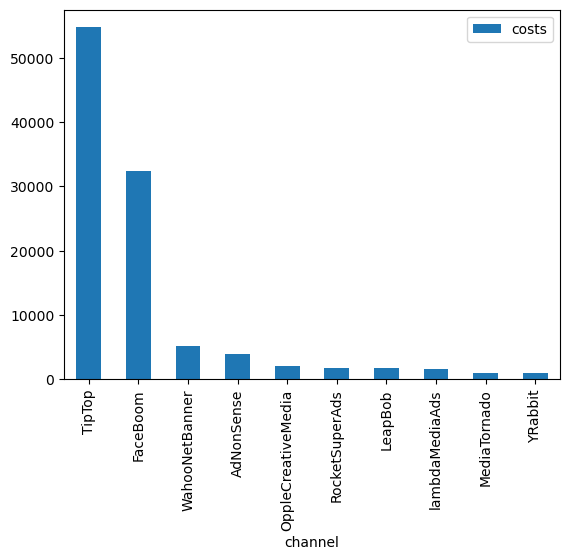

In [22]:
display(marketing.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False))
marketing.groupby('channel').sum().sort_values(by='costs', ascending=False).plot(kind='bar');


Больше всего денег вложено в маркетинг на TipTop и FaceBoom.

#### Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

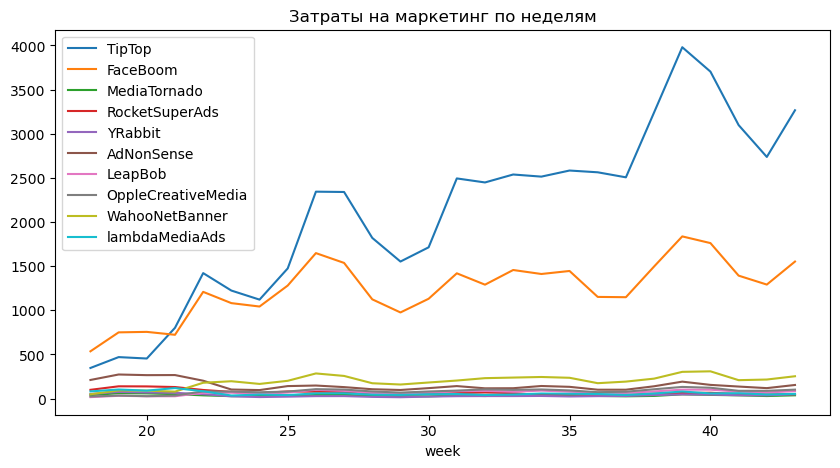

In [23]:
marketing['week'] = pd.to_datetime(marketing['dt']).dt.isocalendar().week
marketing['month'] = pd.to_datetime(marketing['dt']).dt.month
for_plot = marketing.query('channel == "TipTop"').pivot_table(index=['week'], values='costs', aggfunc='sum')
for_plot.columns = ['TipTop']
ax = for_plot.plot(figsize=(10,5), title='Затраты на маркетинг по неделям')
for i in marketing['channel'].unique(): 
    if i=='TipTop':
        continue
    for_plot = marketing.query('channel == @i').pivot_table(index=['week'], values='costs', aggfunc='sum')
    for_plot.columns = [i]
    for_plot.plot(ax=ax)

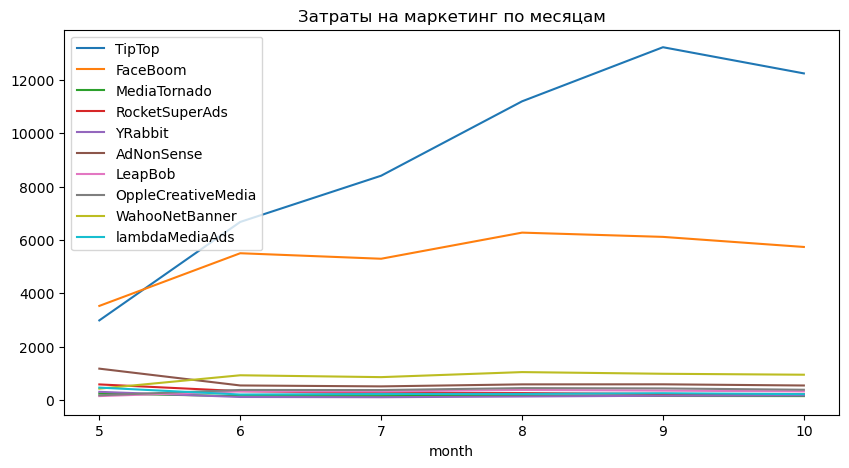

In [24]:
for_plot = marketing.query('channel == "TipTop"').pivot_table(index=['month'], values='costs', aggfunc='sum')
for_plot.columns = ['TipTop']
ax = for_plot.plot(figsize=(10,5), title='Затраты на маркетинг по месяцам')
for i in marketing['channel'].unique(): 
    if i=='TipTop':
        continue
    for_plot = marketing.query('channel == @i').pivot_table(index=['month'], values='costs', aggfunc='sum')
    for_plot.columns = [i]
    for_plot.plot(ax=ax)

Видим что затраты на маркетинг в TipTop и FaceBoom росли.

#### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
organic                    NaN
dtype: float64

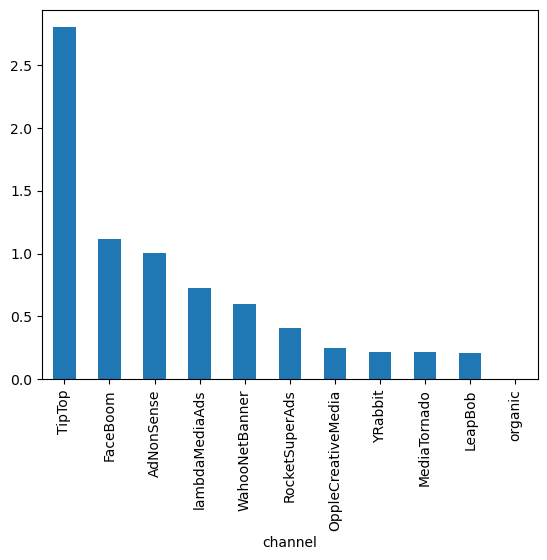

In [25]:
display((marketing.groupby('channel')['costs'].sum() / profiles.groupby('channel')['user_id'].count()).sort_values(ascending=False))
(marketing.groupby('channel')['costs'].sum() / profiles.groupby('channel')['user_id'].count()).sort_values(ascending=False).plot(kind='bar');


Вывод: видим что на TipTop и FaceBoom тратится больше всего денег и затраты всё время росли. В TipTop привлечение каждого посетителя стоит в разы дороже чем в FaceBoom, который занимает 2-е место.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

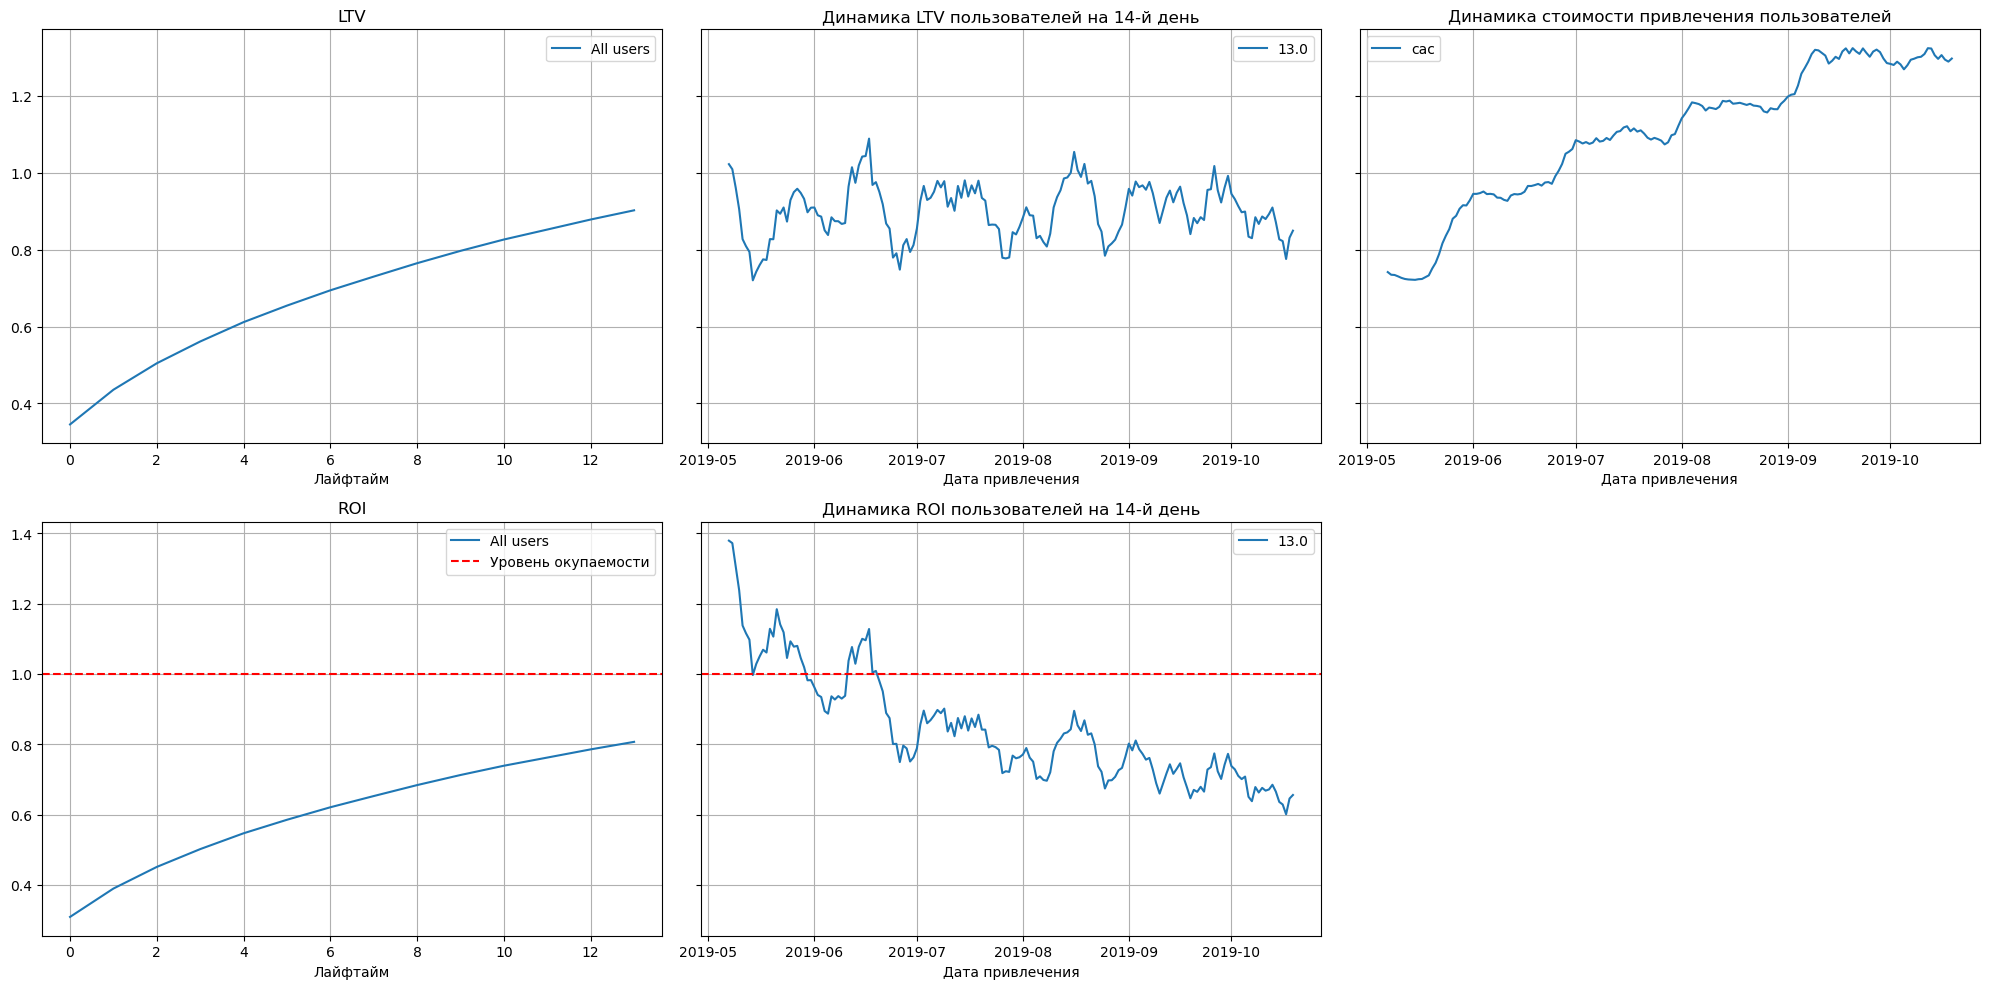

In [26]:
observation_date = datetime.date(datetime(2019,11,1))
horizon_days = 14
data_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles.query("channel!='organic'"),
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=7)

Пользователи перестали окупаться почти сразу, после повышения стоимости привлечения. LTV стабильно колеблется в постоянном коридоре.

#### Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

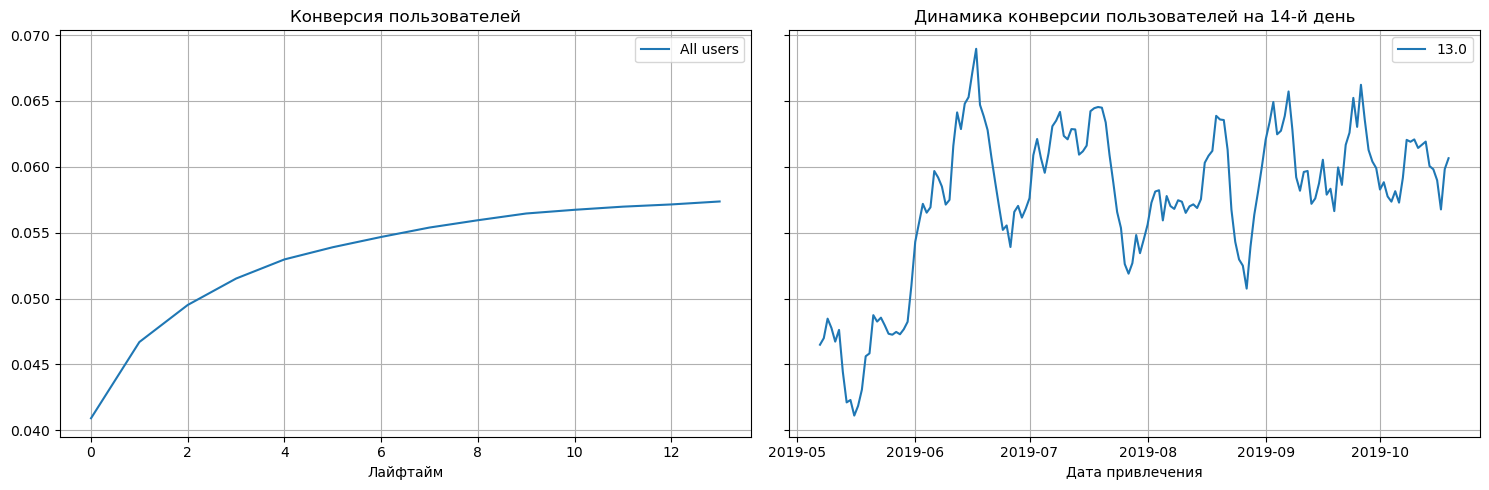

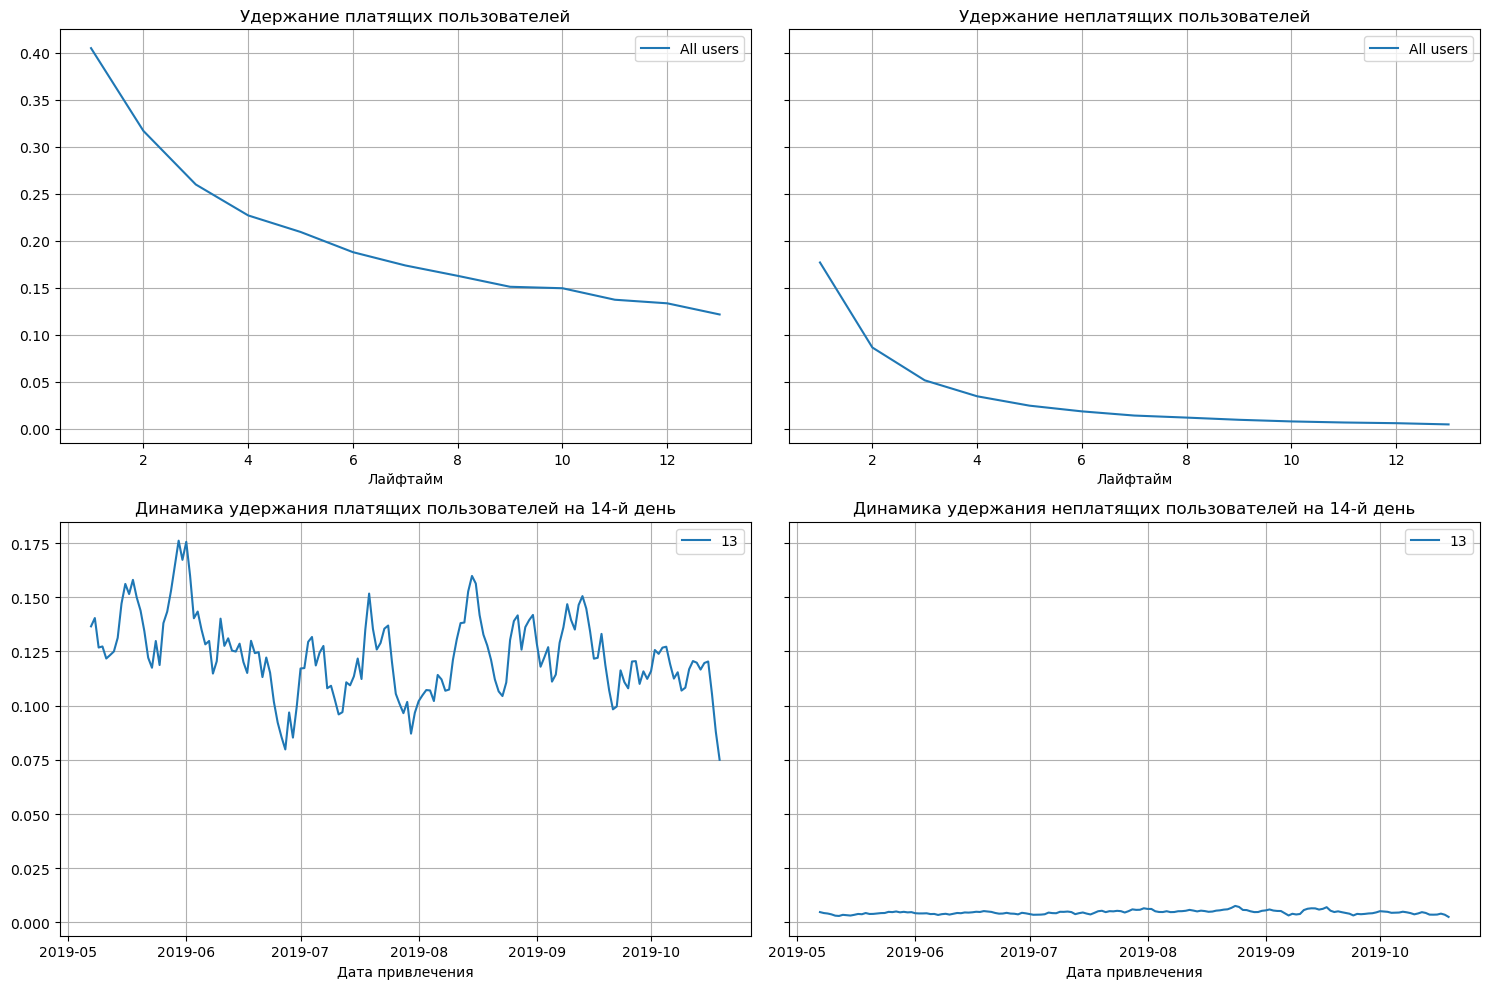

In [27]:
data_raw, retention, retention_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

data_conversion_raw, conversion, conversion_in_time = get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_in_time, horizon_days, window=7)
print()
plot_retention(retention, retention_in_time, horizon_days, window=7)

Конверсия на 14-й день примерно 5,7%. Конверсия сильно выросла в первые 2 месяца и затем колебалась в относительно постоянном коридоре от 5,2% до 6,6%.  
Удержание платящих пользователей на 14-й день - примерно 12,5%, оно за всё время колебалось в коридоре от 7,6%(в конце июня) до 17,5%(в конце мая). 

#### Построим графики конверсии и удержания в разбивке по странам, устройствам и каналам привлечения.

Сначала построим графики по странам.

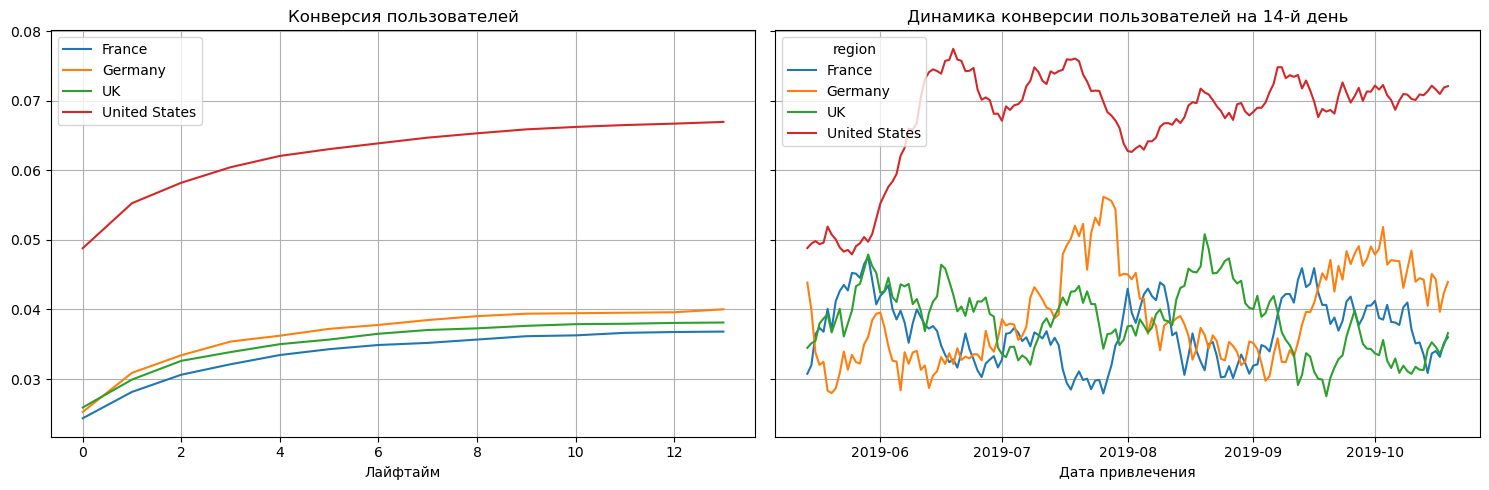

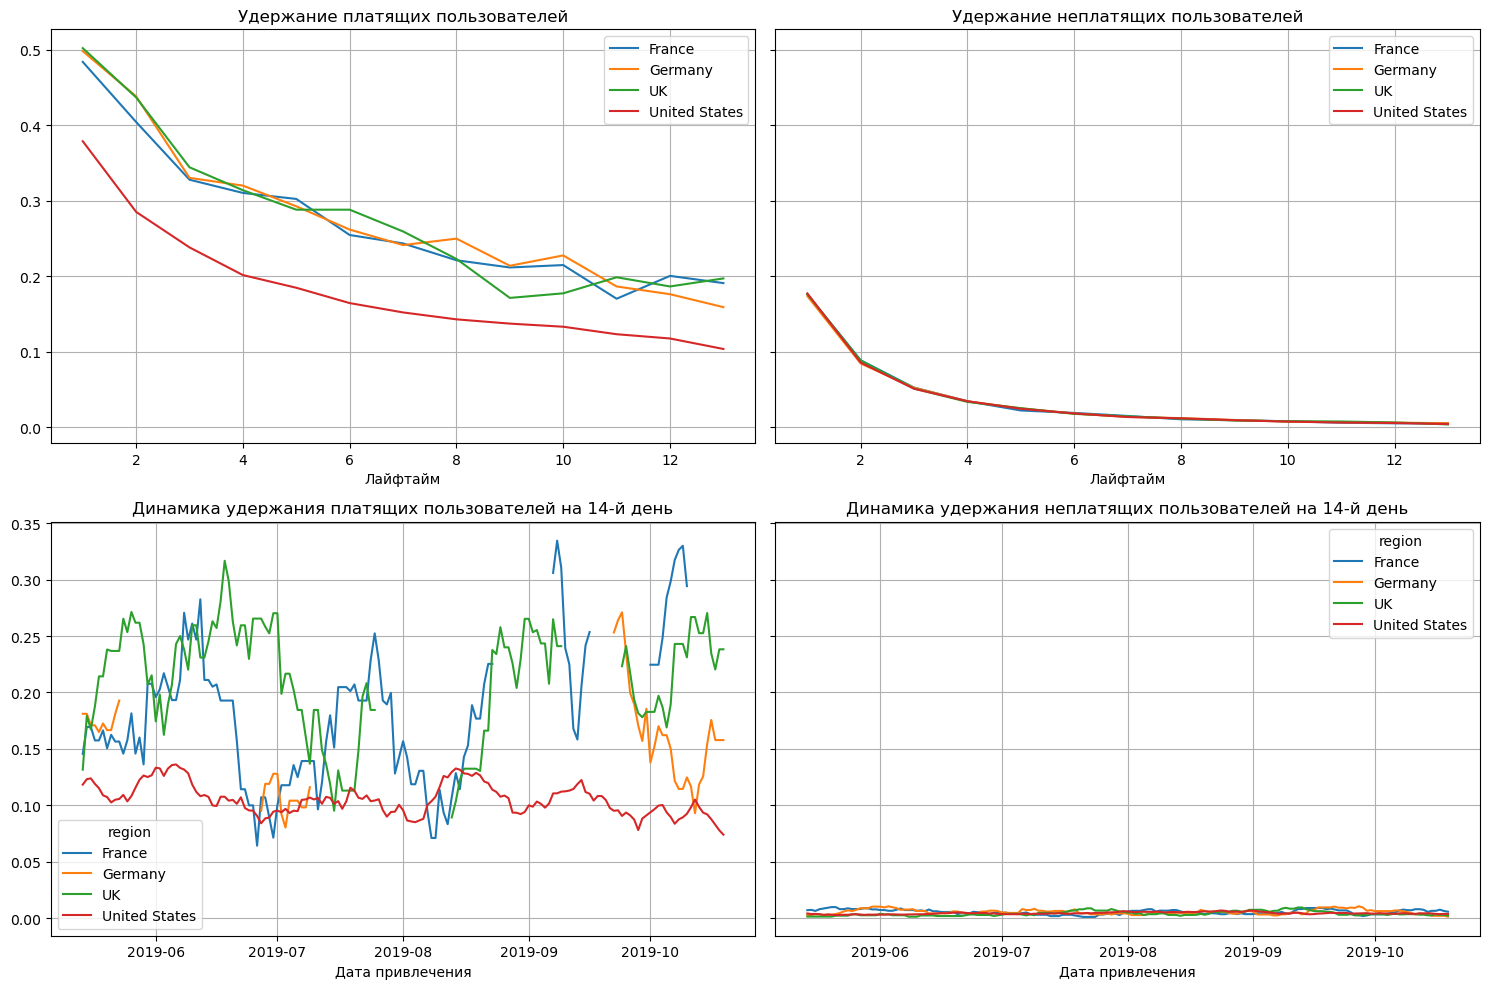

In [28]:
data_raw, retention, retention_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

data_conversion_raw, conversion, conversion_in_time = get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_in_time, horizon_days, window=14)
print()
plot_retention(retention, retention_in_time, horizon_days, window=14)

Видим что в Соединённых Штатах конверсия заметно выше, чем в остальных странах, но удержание заметно ниже. В остальных странах удержание и конверсия примерно схожи между собой.

Построим графики конверсии и удержания в разбивке по устройствам.

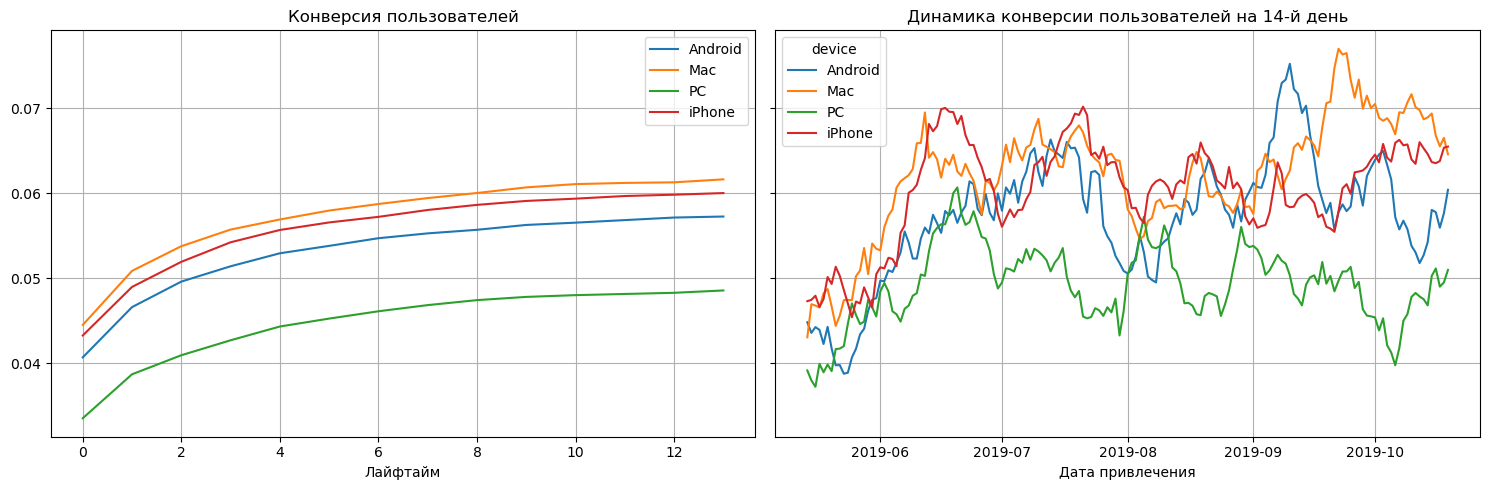

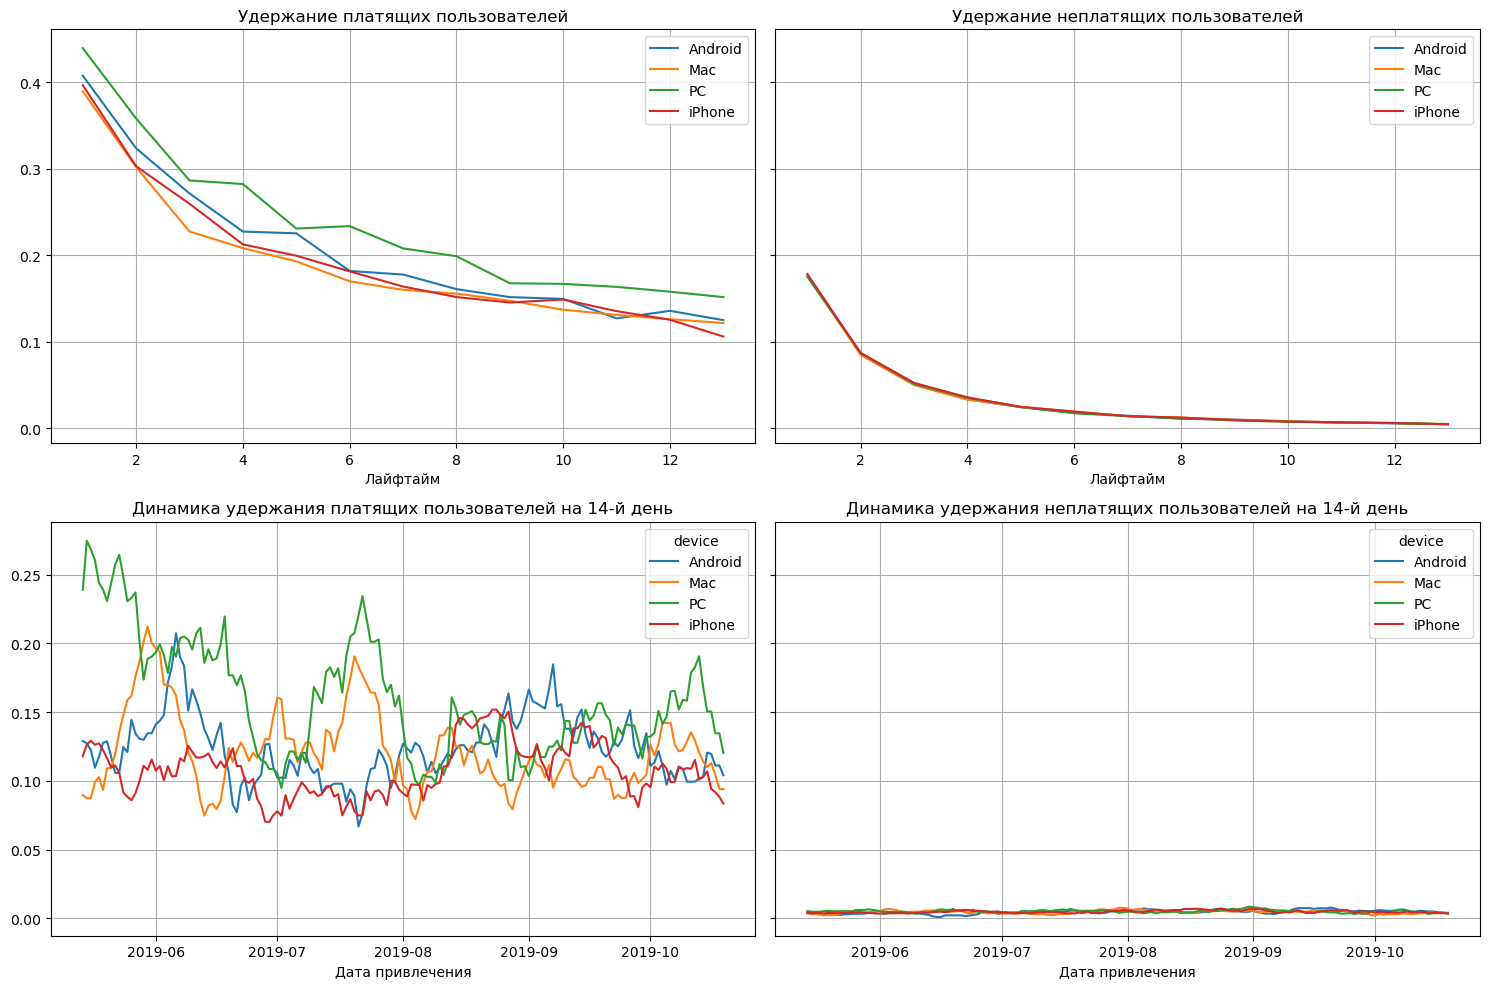

In [29]:
data_raw, retention, retention_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

data_conversion_raw, conversion, conversion_in_time = get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_in_time, horizon_days, window=14)
print()
plot_retention(retention, retention_in_time, horizon_days, window=14)

На PC конверсия в среденем ниже чем на других устройствах, в остальном все поазатели для всех устройств примерно одинаковые. 

Построим графики конверсии и удержания в разбивке по каналам привлечения.

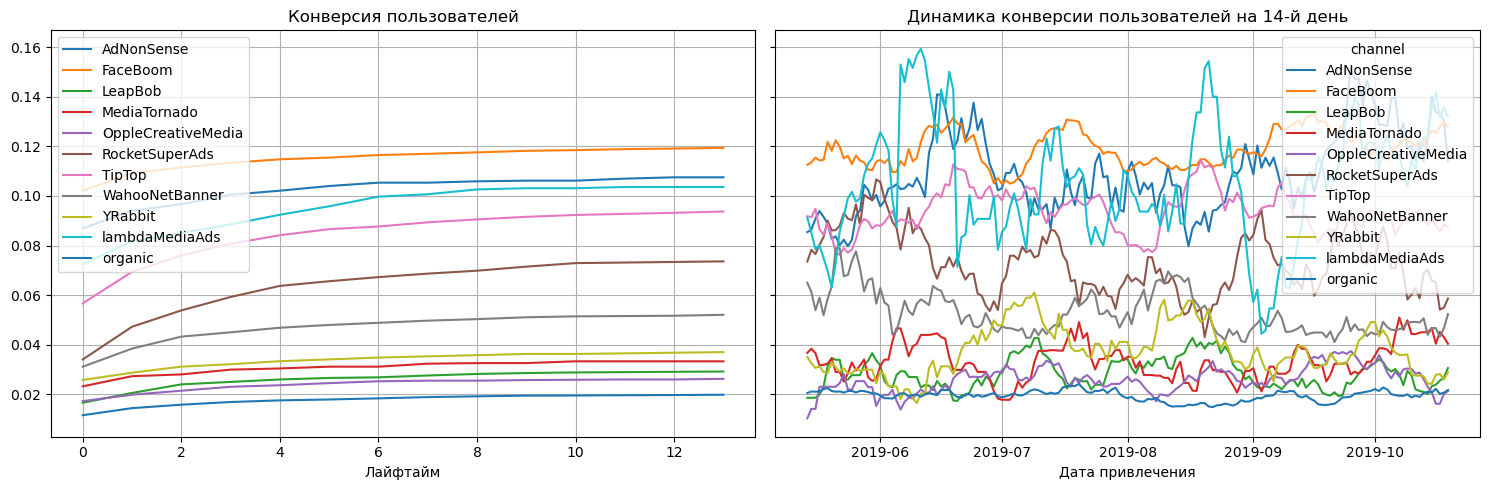

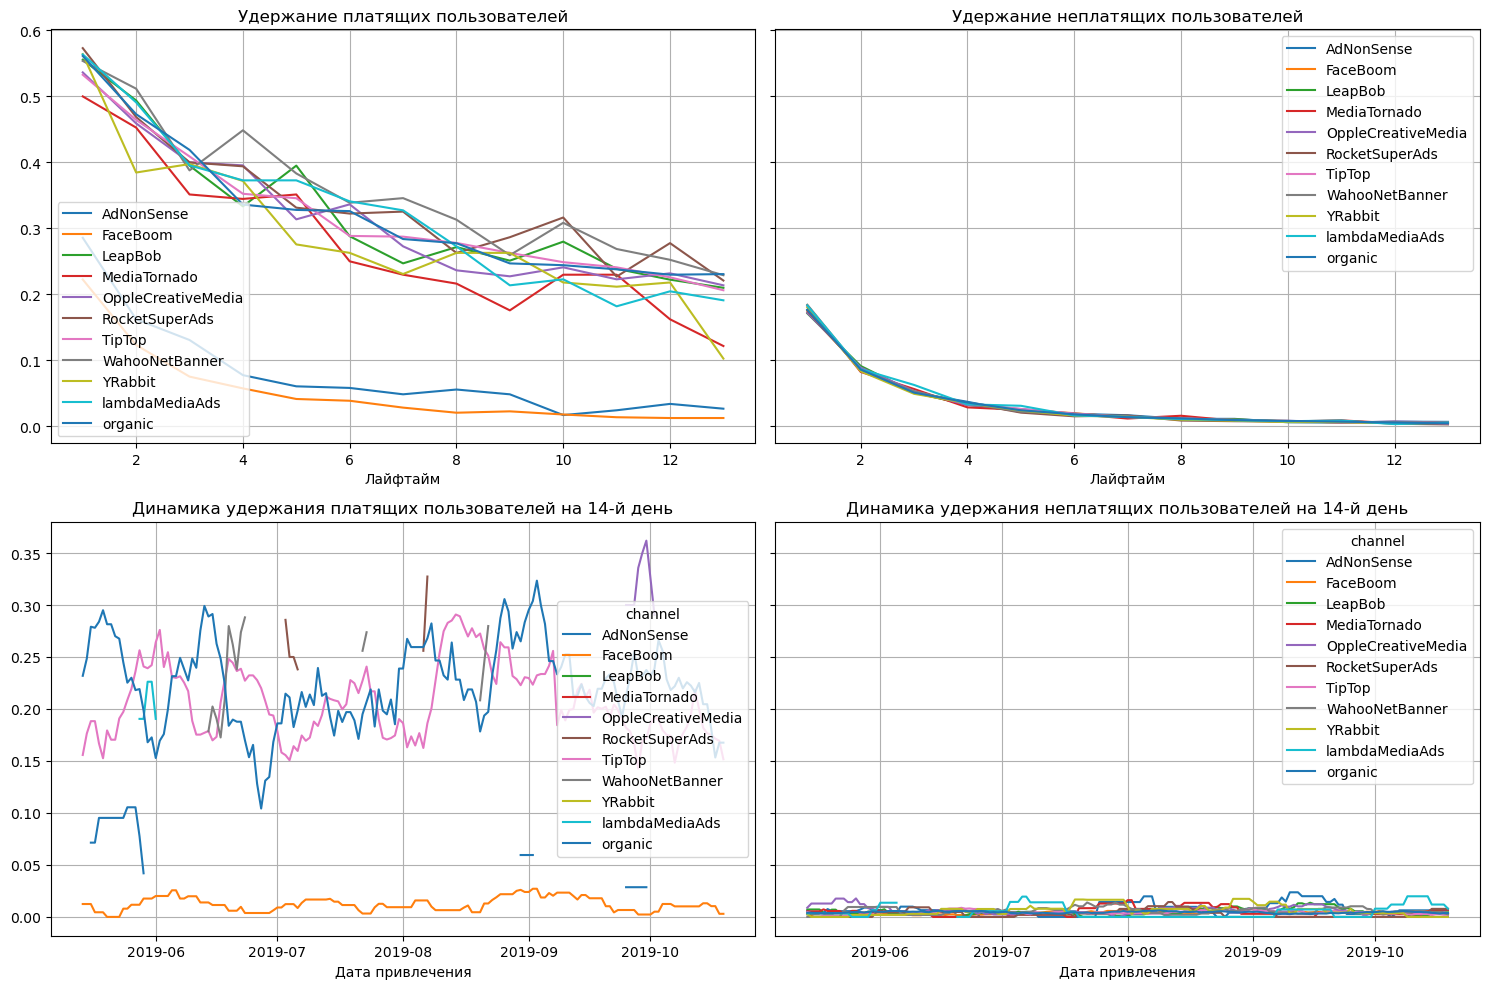

In [30]:
data_raw, retention, retention_in_time = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

data_conversion_raw, conversion, conversion_in_time = get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)

plot_conversion(conversion, conversion_in_time, horizon_days, window=14)
print()
plot_retention(retention, retention_in_time, horizon_days, window=14)

Удержание в FaceBoom и AdNoneSense заметно ниже чем во всех остальных источниках. Конверсия сильно разнится на всех источниках: для каналов organic, OppleCreativeMedia и LeapBob конверсия самая низкая. Для каналов TipTop, lambdaMediaAds, AdNonSense и FaceBoom конверсия самая высокая. 

#### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

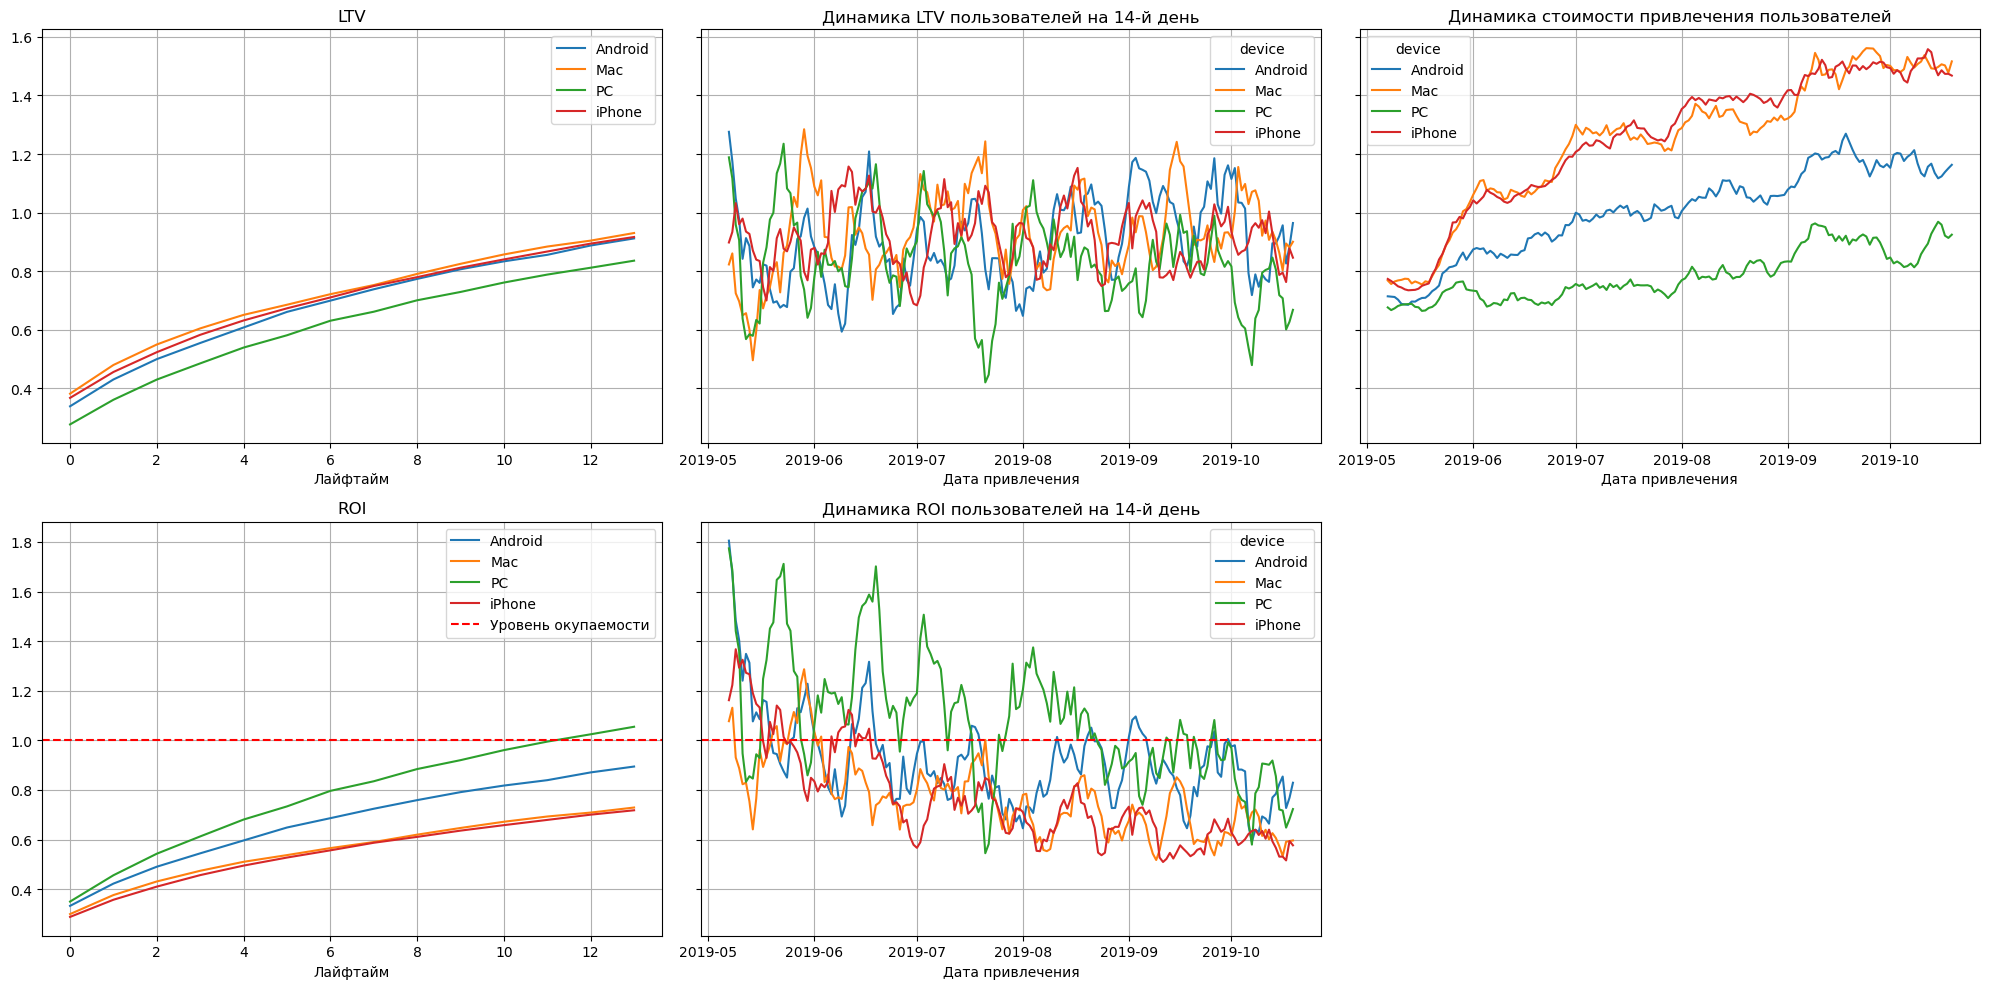

In [31]:
data_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles.query("channel!='organic'"),
    purchases,
    observation_date,
    horizon_days,
    dimensions=['device'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=7)

Видим что окупаются только пользователи PC, и цена привлечения для них самая низкая. А пользователи Mac и iPhone приносят самые большие убытки, цена привлечения для них самая высокая. LTV на всех платформах примерно одинаковый. Тенденция повышения стоимости привлечения есть на всех устройствах.

#### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

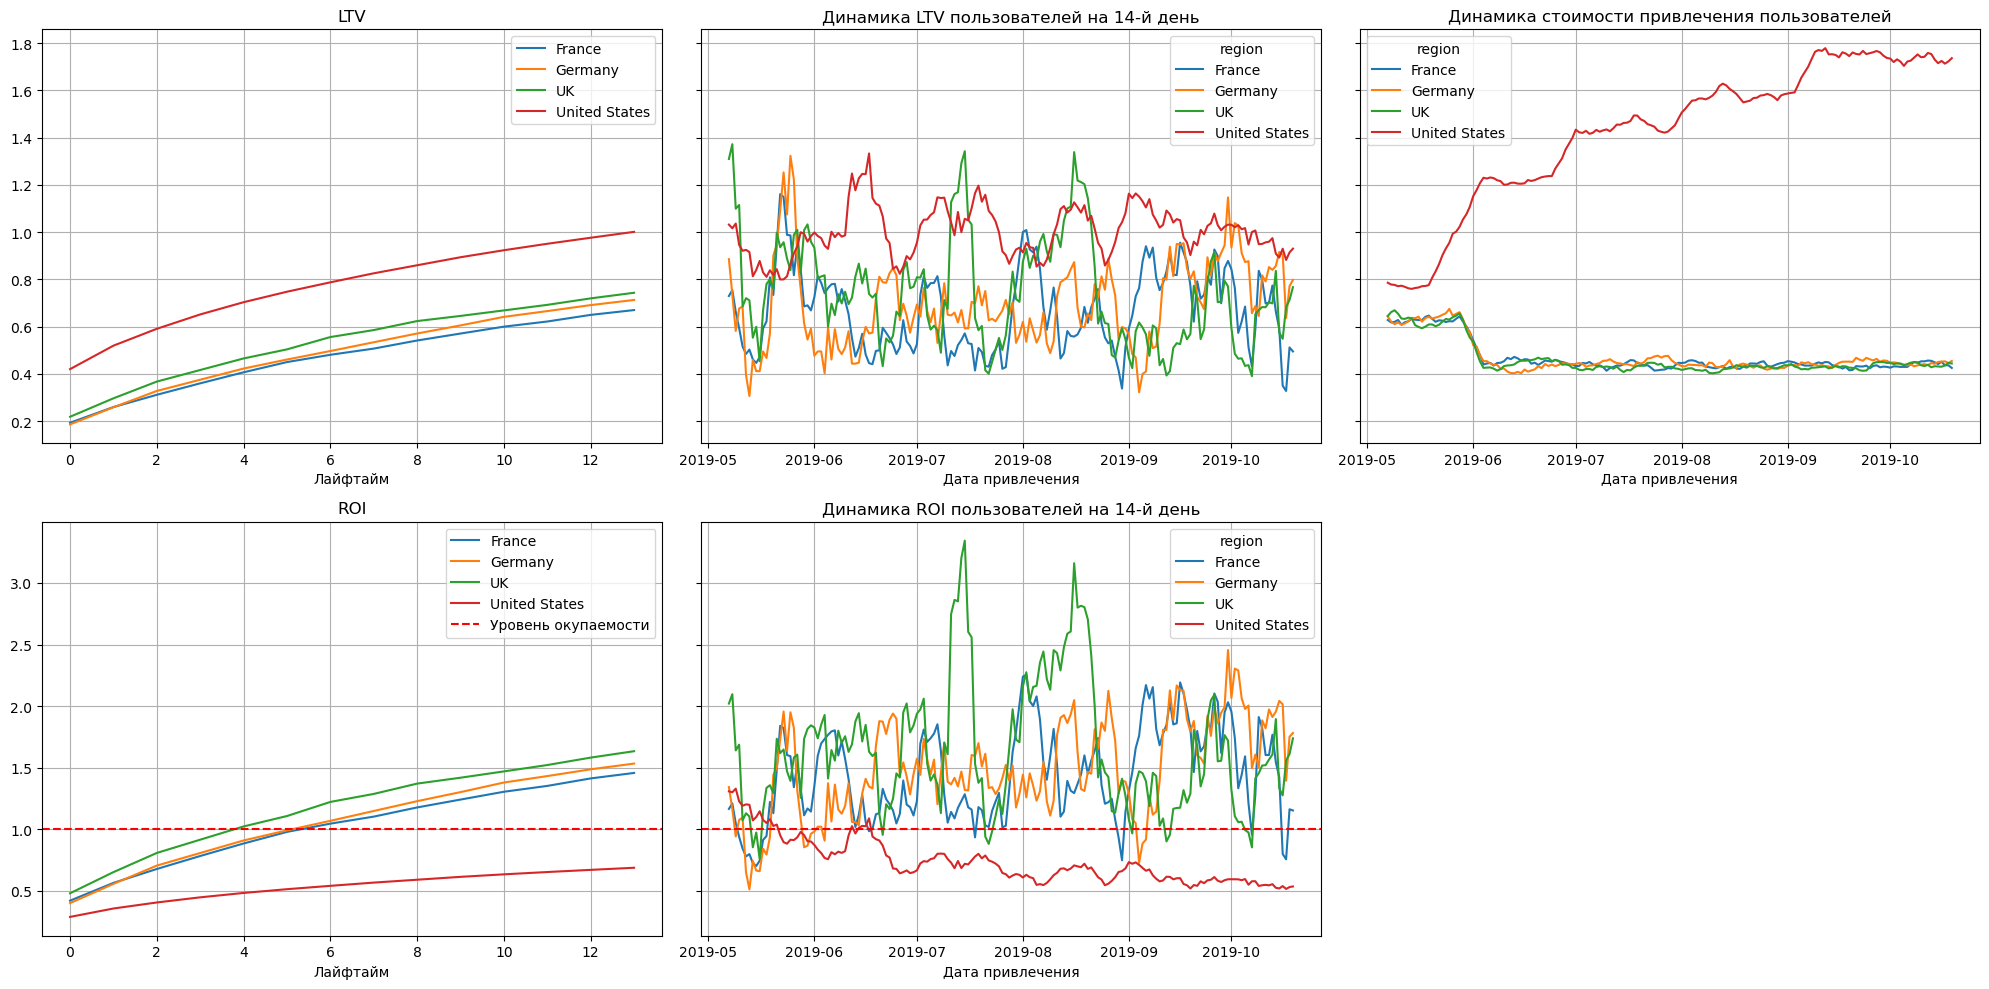

In [32]:
data_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles.query("channel!='organic'"),
    purchases,
    observation_date,
    horizon_days,
    dimensions=['region'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=7)

Видим что значительное повышение стоимости привлечения произошло только для пользователей из Соединённых Штатов, в остальных странах стоимость привлечения наоборот упала и затем не менялась. Пользователи из всех стран в среднем окупаются, кроме Соединённых Штатов.  
LTV для США так же выше, чем в остальных странах, но он не покрывает стоимость привлечения.

#### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

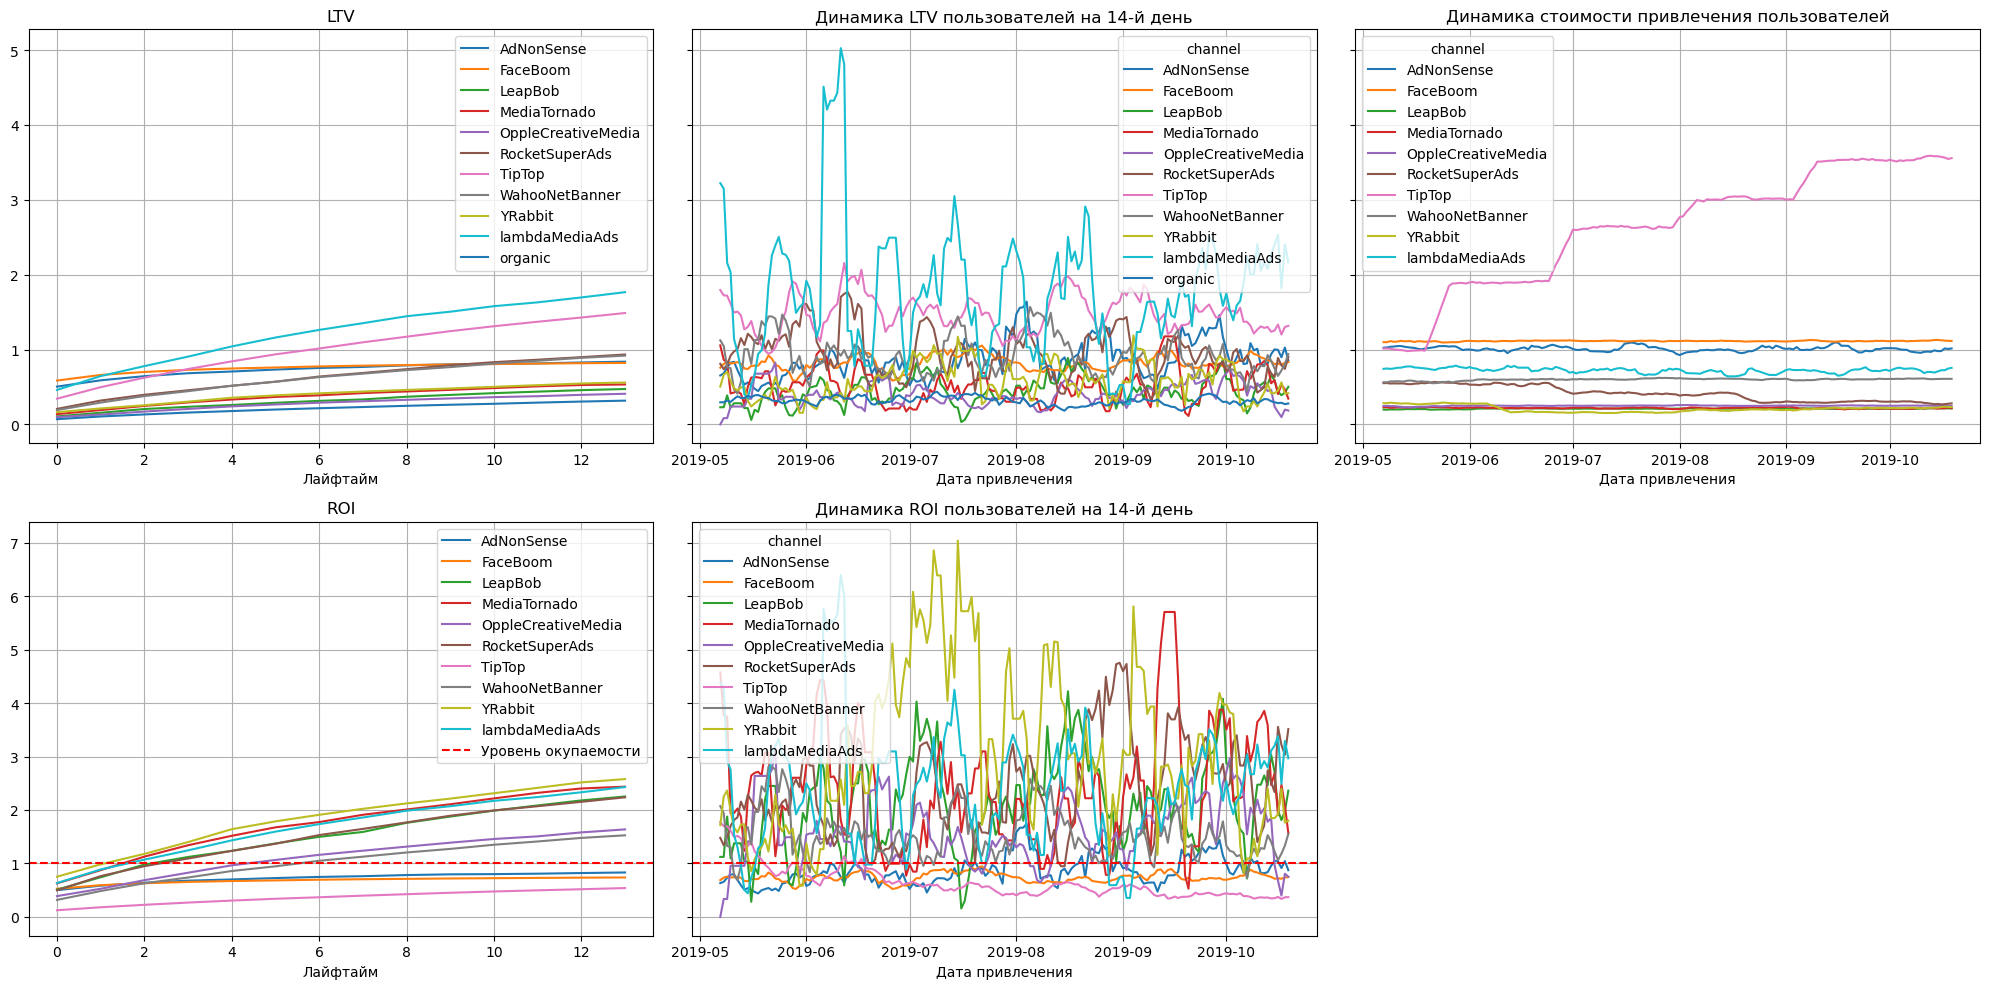

In [33]:
data_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=7)

Видим что значительный рост цены привлечения произошёл для пользователей из TipTop. Так же видим что не окупаются пользователи из TipTop, FaceBoom и AdNonSense.  
Проанализируем так же отдельно для США.

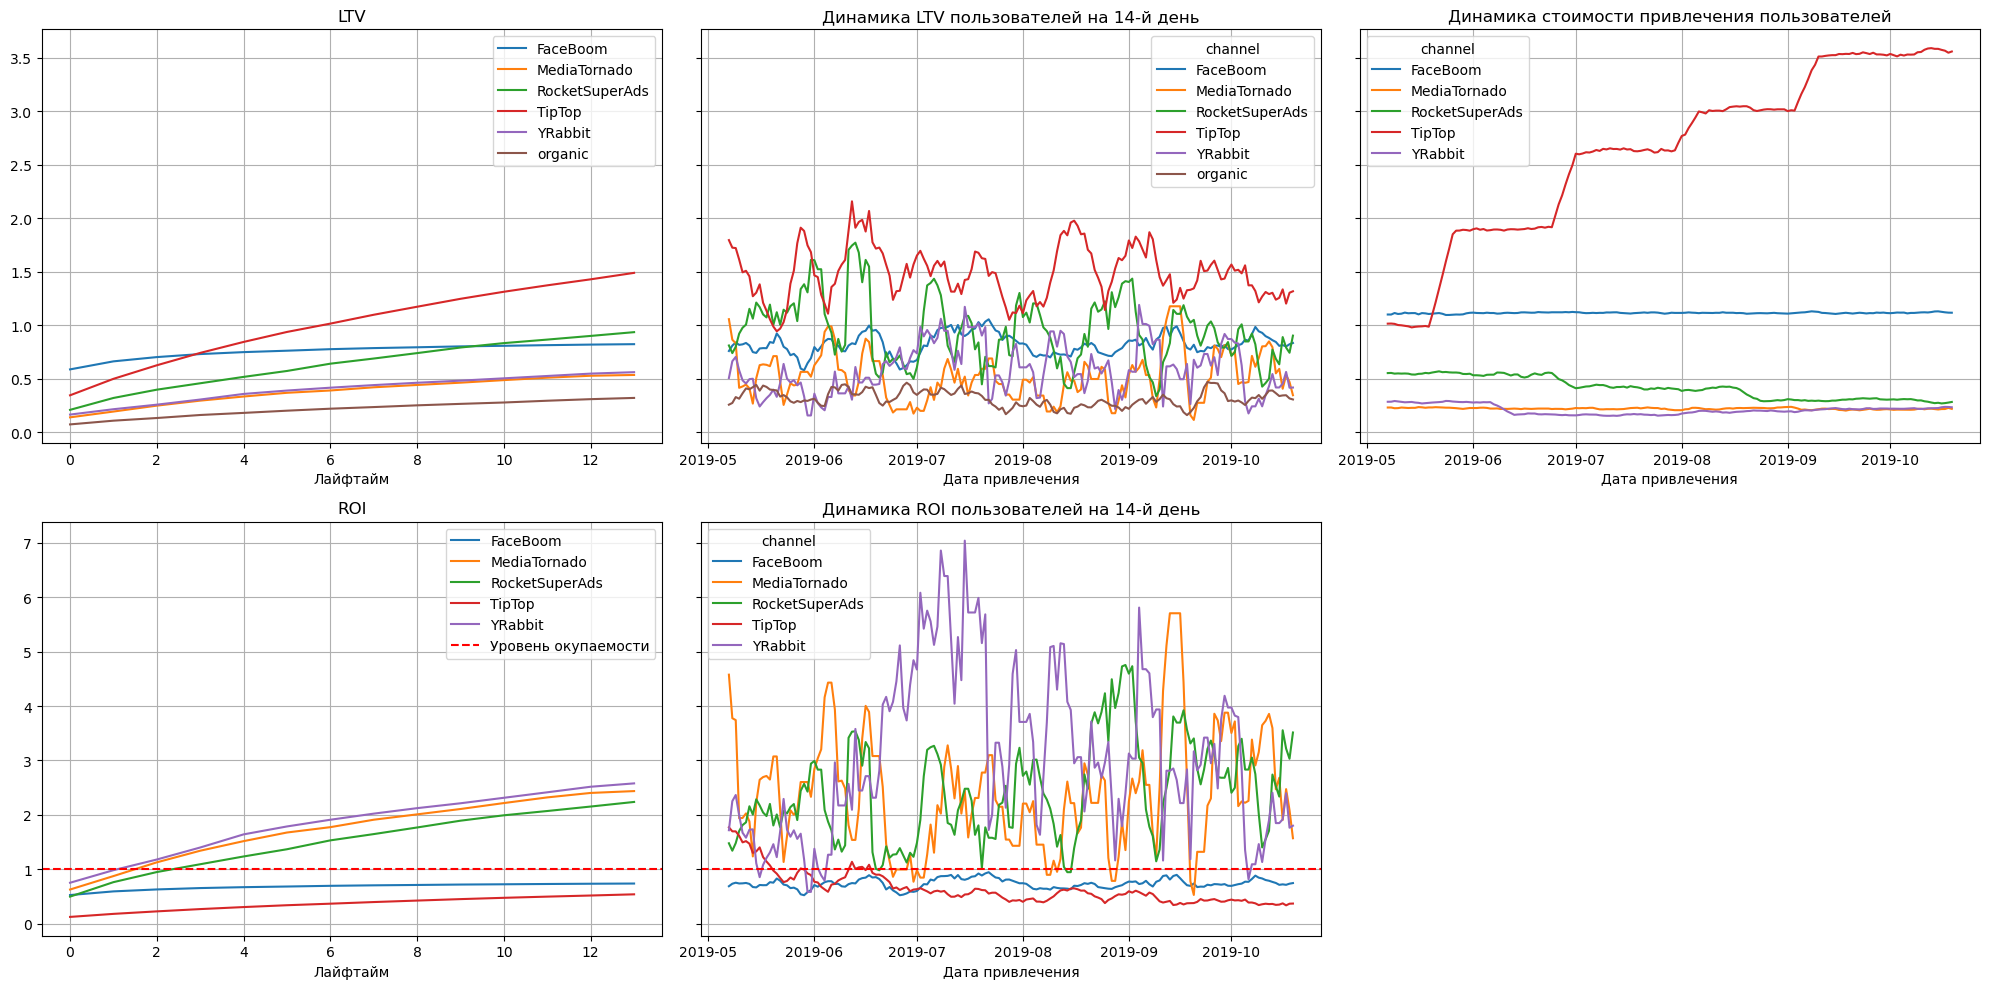

cohort_size       cac       0.0       1.0       2.0       3.0  \
channel                                                                         
FaceBoom              27544  1.113419  0.526040  0.593510  0.629343  0.654599   
MediaTornado           4167  0.219035  0.627684  0.874814  1.127410  1.340729   
RocketSuperAds         4251  0.417431  0.497256  0.763336  0.948932  1.092347   
TipTop                18498  2.757774  0.124575  0.180359  0.226321  0.268272   
YRabbit                4102  0.217087  0.752238  0.983122  1.179250  1.400049   

                     4.0       5.0       6.0       7.0       8.0       9.0  \
channel                                                                      
FaceBoom        0.671035  0.682914  0.695801  0.704818  0.711685  0.719204   
MediaTornado    1.516873  1.675432  1.773841  1.910531  2.008962  2.107371   
RocketSuperAds  1.235204  1.367935  1.531090  1.646391  1.767923  1.892809   
TipTop          0.305449  0.339298  0.367570  0.397585  0.424763  0.451627   
YRabbit         1.641119  1.786814  1.910094  2.022179  2.123045  2.212703   

                    10.0      11.0      12.0      13.0  
channel                                                 
FaceBoom        0.724119  0.729488  0.734210  0.737790  
MediaTornado    2.216726  2.320602  2.402610  2.436519  
RocketSuperAds  1.991795  2.070538  2.152657  2.237019  
TipTop          0.475535  0.497310  0.517679  0.539532  
YRabbit         2.313569  2.414457  2.516446  2.578086

In [34]:
data_raw, ltv_grouped, ltv_in_time, roi_grouped, roi_in_time = get_ltv(
    profiles.query("region=='United States'"),
    purchases,
    observation_date,
    horizon_days,
    dimensions=['channel'],
    ignore_horizon=False,
)
plot_ltv_roi(ltv_grouped, ltv_in_time, roi_grouped, roi_in_time, 14, window=7)
roi_grouped

 В США хорошо окупаются каналы YRabbit, MediaTornado и RocketSuperAds.

- В целом реклама не окупается. 
- По устройствам не окупается реклама на всех устройствах кроме  PC
- По странам не окупается реклама только в United States
- По рекламным каналама реклама не окупается в TipTop, FaceBoom и AdNoneSense  

### Вывод

Большая часть убытков вызвана неокупаемостью маркетинга в каналах TipTop и FaceBoom. Так же убыточна реклама в AdNoneSense. В целом маркетинг на всех устройствах приносит убытки, немного окупается только PC. По странам убытки происходят только в США, маркетинг в остальных странах в целом окупается.


Причины плохой окупаемости:
- Для рекламы в США - низкий ROI в каналах TipTop (53%) и FaceBoom (73%)
- Для канала TipTop - увеличение CAC (от 1 до 3,4)
- Для канала FaceBoom - высокий CAC (CAC = 1,1) и низкое удержание (на 14-й день остаётся только 1,2% пользователей)
- Для канала AdNonSense - высокий CAC (CAC = 1) и низкое удержание (на 14-й день остаётся только 2,6% пользователей)

Рекомендации:
- Пересмотреть маркетинг в TipTop, FaceBoom и AdNonSense.
- Для увеличения окупаемости в США можно увеличить рекламу в каналах YRabbit (ROI = 257%), MediaTornado (ROI = 243%) и RocketSuperAds (ROI = 223%), так как их реклама в США хорошо окупается
- В европе каналы LeapBob и lambdaMediaAds окупаются лучше всего (ROI 225% и 242%), можно увеличить рекламу в этих каналах